# Visualizing CNN Layer Outputs

### David Hoelzer
>SANS Fellow, Operations Chief - EnclaveForensics  
>Author of SEC595: Applied Data Science and Machine Learning for Cybersecurity Professionals  
>https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/

## Outline

* Build a simple CNN solution for a toy dataset and show how to extract and visualize CNN layers
* Take a prebuilt model that solves a real problem
    - Identify structure of layers
    - Extract and test CNN layers
    - Visualize the output!

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt


In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [12]:
x_train = x_train.reshape(*x_train.shape, -1)
x_test = x_test.reshape(*x_test.shape, -1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

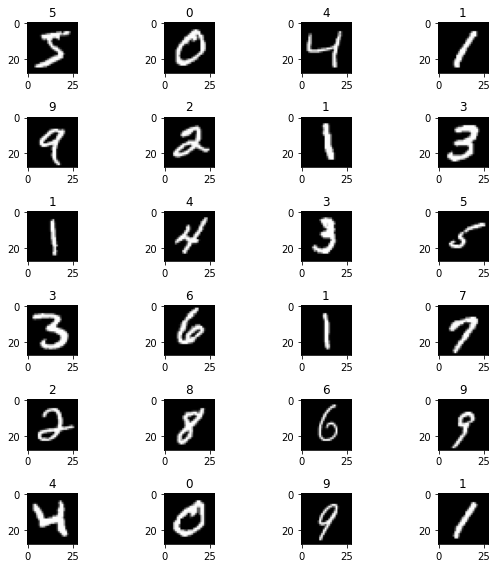

In [19]:
fig = plt.figure(figsize=(8,8))
for i in range(24):
    fig.add_subplot(6,4,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i].argmax())

plt.tight_layout()
plt.show()

In [22]:
model = Sequential()
model.add(layers.Conv2D(8,6, activation='relu', name='first', input_shape=x_train[0].shape))
model.add(layers.Conv2D(16,4, activation='relu', name='second'))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=4)

2022-01-21 12:21:41.540405: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 12:21:41.540861: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/4


2022-01-21 12:21:42.669022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 28s 13ms/step - loss: 0.3559 - accuracy: 0.8941
Epoch 2/4
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0779 - accuracy: 0.9777
Epoch 3/4
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0562 - accuracy: 0.9834
Epoch 4/4
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0439 - accuracy: 0.9869


In [29]:
model.get_layer("first").get_weights()[0].shape

(6, 6, 1, 8)

In [30]:
visualize = Sequential()
visualize.add(layers.Conv2D(8,6, activation='relu', name='target', kernel_initializer='ones', input_shape=x_train[0].shape))
visualize.compile()


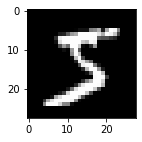

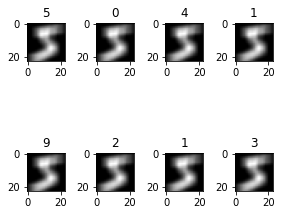

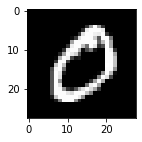

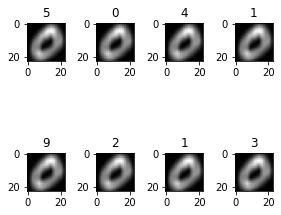

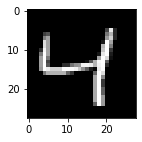

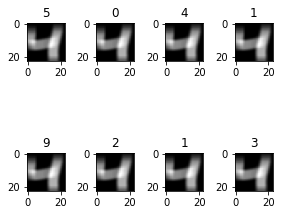

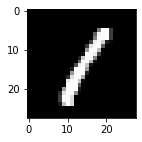

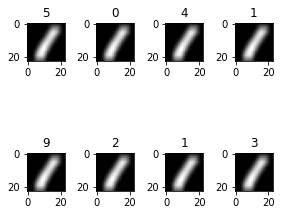

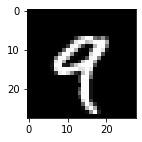

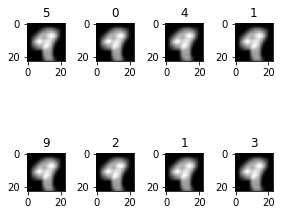

In [32]:
for x in range(5):
    output = visualize.predict(x_train[x].reshape(-1,28,28,1))
    plt.figure(figsize=(2,2))
    plt.imshow(x_train[x], cmap='gray')
    plt.show()

    fig = plt.figure(figsize=(4,4))
    for i in range(8):
        fig.add_subplot(2,4,i+1)
        image = output[0,:,:,i]
        plt.imshow(image, cmap='gray')
        plt.title(y_train[i].argmax())

    plt.tight_layout()
    plt.show()


In [34]:
visualize.get_layer('target').set_weights(model.get_layer('first').get_weights())

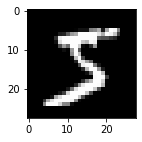

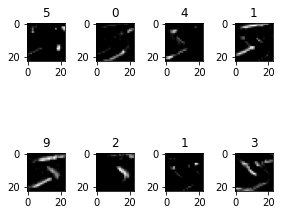

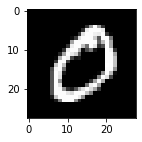

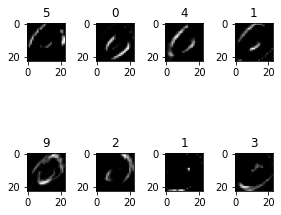

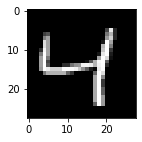

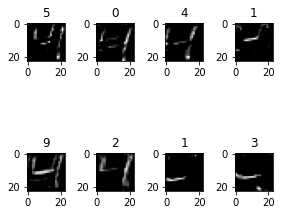

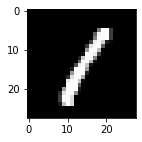

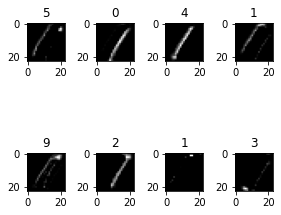

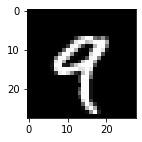

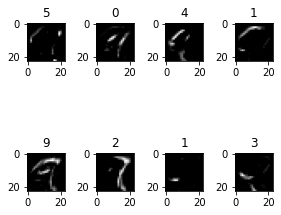

In [35]:
for x in range(5):
    output = visualize.predict(x_train[x].reshape(-1,28,28,1))
    plt.figure(figsize=(2,2))
    plt.imshow(x_train[x], cmap='gray')
    plt.show()

    fig = plt.figure(figsize=(4,4))
    for i in range(8):
        fig.add_subplot(2,4,i+1)
        image = output[0,:,:,i]
        plt.imshow(image, cmap='gray')
        plt.title(y_train[i].argmax())

    plt.tight_layout()
    plt.show()

In [36]:
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display
from os import listdir
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models

WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
SYMBOL_SET  =    "0123456789"
NUM_SYMBOLS = len(SYMBOL_SET)

def onehot(x):
    b = np.zeros(NUM_SYMBOLS)
    b[x] = 1
    return b

def generate_captcha(return_image=False):
    fonts = [i for i in filter(lambda i:i[-3:]=="ttf", listdir("fonts"))]
    charset=list(SYMBOL_SET)
    while 1:
        x_position = 0
        y_position = 0
        captcha_label = ""
        position_labels = np.array([])
        img = Image.new('RGB', (WIDTH,HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)
        for i in range(0,NUMCHARS):
            font = ImageFont.truetype(f'fonts/{fonts[randrange(len(fonts))]}', randrange(MINSIZE,MAXSIZE))
            letter = SYMBOL_SET[randrange(NUM_SYMBOLS)]
            x_position = x_position+randrange(0,MINX)
            y_position = randrange(MINY,40)
            position = (x_position, y_position)
            coords = canvas.textbbox(position, letter, font)
            canvas.text(position, letter, font=font, fill=(0,0,0), anchor="la")
            captcha_label = f'{captcha_label}{letter}'
            coords = [i for i in coords]
            position_labels = np.append(position_labels,coords)
            x_position = coords[2]
        x = np.array(list(img.tobytes())).reshape(WIDTH,HEIGHT,3).astype(np.float64)/255.0
        y = position_labels
        letters = list(captcha_label)
        letters = np.array([onehot(int(i)) for i in letters])
#        y = [item for sublist in y for item in sublist]
#        y.extend([i for i in position_labels])
#        y = np.array(y)
        if return_image:
            yield x,(position_labels, letters[0], letters[1], letters[2], letters[3]),img
        else:
            yield x,(position_labels, letters[0], letters[1], letters[2], letters[3])

def draw_boxes(image, truth, predicted=[]):
    colors = [(255,0,0), (0,255,0), (0,0,255),(255,0,255), (255,255,0),(0,255,255)]
    canvas = ImageDraw.Draw(image)
    # Parse into coordinates, one for each symbol)
    coords = np.array(truth).reshape(NUMCHARS, 4)
    for color_index, box_coords in enumerate(coords):
        this_box = list(box_coords)
        canvas.rectangle(this_box, outline=colors[color_index], width=1)
    display(image)
    
import tensorflow as tf
dataset = tf.data.Dataset.from_generator(generate_captcha,
            output_signature=(
                 tf.TensorSpec(shape=(WIDTH,HEIGHT,3), dtype=tf.float64),
                 (tf.TensorSpec(shape=(16), dtype=tf.float32),
                  tf.TensorSpec(shape=(10), dtype=tf.float32),
                  tf.TensorSpec(shape=(10), dtype=tf.float32),
                  tf.TensorSpec(shape=(10), dtype=tf.float32),
                  tf.TensorSpec(shape=(10), dtype=tf.float32))
            ))
              
dataset = dataset.batch(batch_size=32)

2022-01-21 12:36:06.251772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CAPTCHA Solve: 2 0 8 0


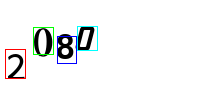

CAPTCHA Solve: 7 5 0 6


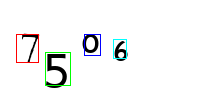

CAPTCHA Solve: 3 2 6 9


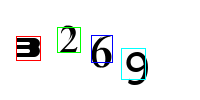

CAPTCHA Solve: 9 3 0 8


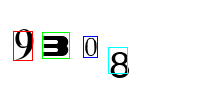

CAPTCHA Solve: 5 5 3 6


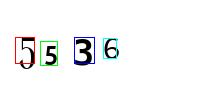

In [37]:
model = tf.keras.models.load_model("../data/models/CAPTCHA-CNN-Functional-Split.h5")
for i in range(5):
    (x, y, image) = next(generate_captcha(return_image=True))
    results  = model.predict(x.reshape(-1,WIDTH,HEIGHT,3))
    print("CAPTCHA Solve:",results[1].argmax(),results[2].argmax(),results[3].argmax(),results[4].argmax())
    canvas = ImageDraw.Draw(image)
    coords = results[0][0][0:4]
    canvas.rectangle(coords, outline=(255,0,0), width=1)
    coords = results[0][0][4:8]
    canvas.rectangle(coords, outline=(0,255,0), width=1)
    coords = results[0][0][8:12]
    canvas.rectangle(coords, outline=(0,0,255), width=1)
    coords = results[0][0][12:16]
    canvas.rectangle(coords, outline=(0,255,255), width=1)
    
    display(image)

In [40]:
visualize = Sequential()
visualize.add(layers.Conv2D(8, 6, activation='relu', input_shape=(200,100,3)))
visualize.compile()

In [44]:
visualize.get_layer('conv2d').set_weights(model.get_layer("Input_CNN").get_weights())

In [48]:
(x,y,image) = next(generate_captcha(return_image=True))

In [49]:
results = visualize.predict(x.reshape(1,200,100,3))
results[0].shape

2022-01-21 12:44:44.608073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(195, 95, 8)

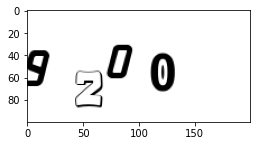

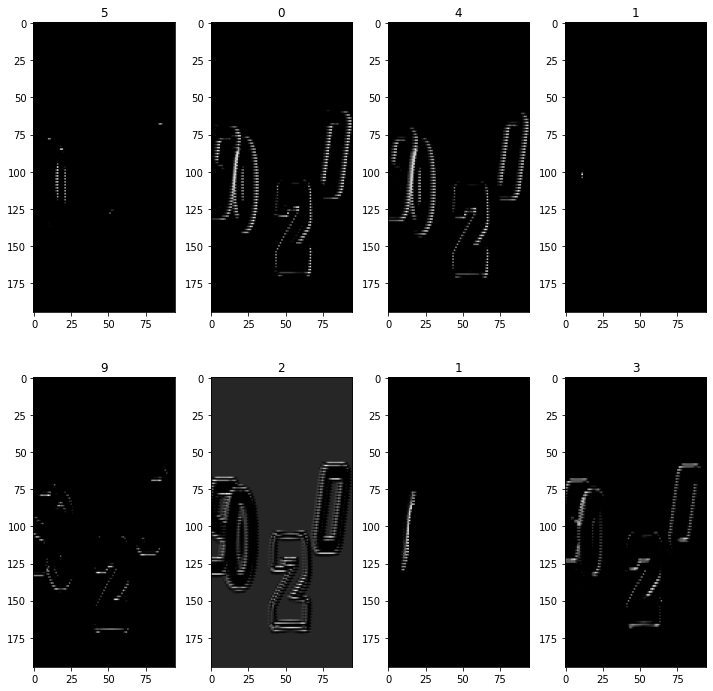

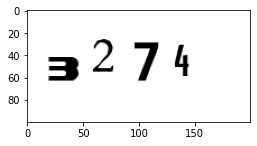

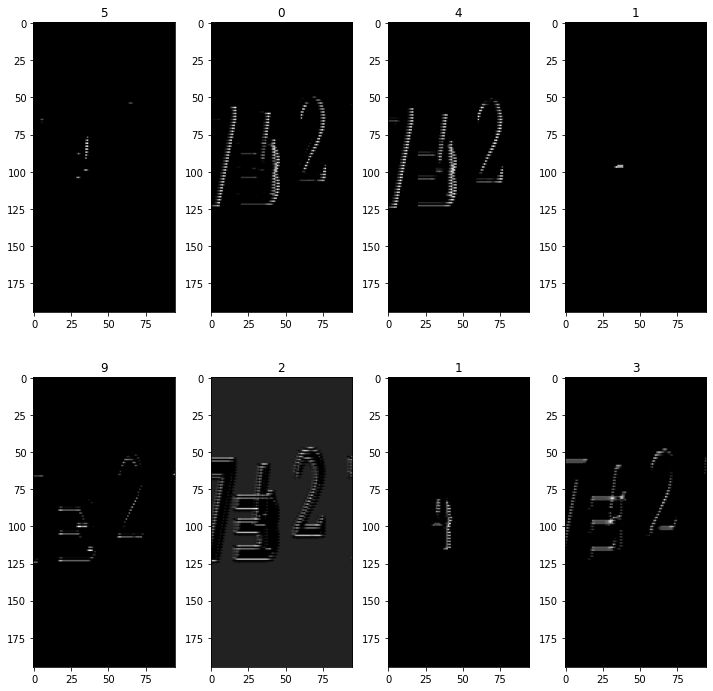

In [50]:
for x in range(2):
    (x, y, image) = next(generate_captcha(return_image=True))
    output = visualize.predict(x.reshape(-1,*x.shape))
    plt.figure(figsize=(4,4))
    plt.imshow(image, cmap='gray')
    plt.show()

    fig = plt.figure(figsize=(10,10))
    for i in range(8):
        fig.add_subplot(2,4,i+1)
        image = output[0,:,:,i]
        plt.imshow(image, cmap='gray')
        plt.title(y_train[i].argmax())

    plt.tight_layout()
    plt.show()


In [39]:
model.get_config()

{'name': 'CAPTCHA_solver',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 200, 100, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_5'},
   'name': 'input_5',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'Input_CNN',
    'trainable': True,
    'dtype': 'float32',
    'filters': 8,
    'kernel_size': (6, 6),
    'strides': (1, 1),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'Input_CNN',
   'inbound_nodes': [[['input_5', 0, 0, {}]]]},
  {'class_name': 'MaxPooli